# Modelling a SFR Hexagonal Assembly

In this example I will create a hexagonal bundle that is used in SFR Reactors.

The code is developed using the Git Project concernig modelling SFR Reactors provided by OpenMC  ([Example Jupyter Notebooks](https://github.com/openmc-dev/openmc/wiki/Example-Jupyter-Notebooks)) as example!

## References:
* A. Facchini, V. Giusti, R. Ciolini, K. Tucek, D. Thomas, E. D'Agata, *"Detailed Neutornics Study of the Power Evolution for the European Sodium Fast Reactor During a Positive Insertion of Reactivity"*, Nuc. Eng. Design 313 1-9 (2017)
* A. Ponomarev, A. Bednarova, K. Mikityuk, *"New Sodium Fast Reactor Neutronics Benchmark"*, PHYSOR 2018

In [1]:
import numpy as np
import openmc

In [2]:
#MATERIAL definition for SFR simulations
#since we have an outer and inner region in the core, with different fuel compositions, we define single elements and then mix them

#Uranium nuclides
u238 = openmc.Material(name='U238')
u238.add_nuclide('U238', 1.0)
u238.set_density('g/cm3', 10.0)

u235 = openmc.Material(name='U235')
u235.add_nuclide('U235', 1.0)
u235.set_density('g/cm3', 10.0)

#Plutonium nuclides
pu238 = openmc.Material(name='Pu238')
pu238.add_nuclide('Pu238', 1.0)
pu238.set_density('g/cm3', 10.0)

pu239 = openmc.Material(name='Pu239')
pu239.add_nuclide('Pu239', 1.0)
pu239.set_density('g/cm3', 10.0)

pu240 = openmc.Material(name='Pu240')
pu240.add_nuclide('Pu240', 1.0)
pu240.set_density('g/cm3', 10.0)

pu241 = openmc.Material(name='Pu241')
pu241.add_nuclide('Pu241', 1.0)
pu241.set_density('g/cm3', 10.0)

pu242 = openmc.Material(name='Pu242')
pu242.add_nuclide('Pu242', 1.0)
pu242.set_density('g/cm3', 10.0)

#Minor Actinide for transmutation purposes: Americium
am241 = openmc.Material(name='Am241')
am241.add_nuclide('Am241', 1.0)
am241.set_density('g/cm3', 10.0)

#Oxygen
o16 = openmc.Material(name='O16')
o16.add_nuclide('O16', 1.0)
o16.set_density('g/cm3', 10.0)

#Helium
helium = openmc.Material(name='Helium')
helium.add_nuclide('He3', 4.8e-10)
helium.add_nuclide('He4', 2.4e-04)

#Sodium Na23 coolant fluid
sodium = openmc.Material(name='Na Coolant')
sodium.add_nuclide('Na23', 1.0)
sodium.set_density('g/cm3', 0.96)

#SS cladding made of Cu and Al2O3
cu63 = openmc.Material(name='Cu63')
cu63.set_density('g/cm3', 10.0)
cu63.add_nuclide('Cu63', 1.0)

Al2O3 = openmc.Material(name='Al2O3')
Al2O3.set_density('g/cm3', 10.0)
Al2O3.add_element('O', 3.0)
Al2O3.add_element('Al', 2.0)

#Inner region fuel, Outer region fuel, Coolant and Cladding materials

fuel = openmc.Material.mix_materials(
    [u235, u238, pu238, pu239, pu240, pu241, pu242, am241, o16],
    [0.0019, 0.7509, 0.0046, 0.0612, 0.0383, 0.0106, 0.0134, 0.001, 0.1181],
    'wo', name='Mixed Oxide Fuel Inner')

fuel_outer = openmc.Material.mix_materials(
    [u235, u238, pu238, pu239, pu240, pu241, pu242, am241, o16],
    [0.0018, 0.73, 0.0053, 0.0711, 0.0445, 0.0124, 0.0156, 0.0017, 0.1176],
    'wo')

filling_gas = helium

coolant = sodium

cladding = openmc.Material.mix_materials(
    [cu63, Al2O3],
    [0.997, 0.003],
    'wo', name='Cladding SS')

#EXPORT of material definitions
materials = openmc.Materials([fuel, fuel_outer, filling_gas, coolant, cladding])
materials.export_to_xml()

In [3]:
#GEOMETRY definitions

#SINGLE FUEL PIN
r1 = 0.943/2 #cm
r2 = 0.973/2 #cm
r3 = 1.073/2 #cm

#1) planes
fuel_cylinder = openmc.ZCylinder(r=r1)
clad_in_cylinder = openmc.ZCylinder(r=r2)
clad_out_cylinder = openmc.ZCylinder(r=r3)

upper_limit = openmc.ZPlane(z0=+50, boundary_type='vacuum')
lower_limit = openmc.ZPlane(z0=-50, boundary_type='vacuum')

#2)regions
fuel_region = -fuel_cylinder & -upper_limit & +lower_limit
gap_region = +fuel_cylinder & -clad_in_cylinder & -upper_limit & +lower_limit
clad_region =  -clad_in_cylinder & + clad_out_cylinder & -upper_limit & +lower_limit
coolant_region = +clad_out_cylinder & -upper_limit & +lower_limit

#3)Cells
fuel_cell = openmc.Cell(fill=fuel, region=fuel_region)
fuel_outer_cell = openmc.Cell(fill=fuel_outer, region=fuel_region)
helium_cell = openmc.Cell(fill=filling_gas, region=gap_region)
coolant_cell = openmc.Cell(fill=coolant, region=coolant_region)
clad_cell = openmc.Cell(fill=cladding, region=clad_region)

#4)Universes
fuel_rod_universe = openmc.Universe(cells=[fuel_cell, helium_cell, coolant_cell, clad_cell])
fuel_rod_outer_universe = openmc.Universe(cells=[fuel_outer_cell, helium_cell, coolant_cell, clad_cell])
empty_cell = openmc.Cell(fill=coolant)
empty_channel_universe = openmc.Universe(cells=[empty_cell])


In [4]:
#ASSEMBLIES: now we can create different assemblies that are characterized by different positions of sub-channels
pitch = 1.24 #cm
assembly_pitch = pitch*17

#1) INNER POSITION FUEL ASSEMBILIES
fuel_assembly_lat = openmc.HexLattice(name='Inner Position Lattice')
fuel_assembly_lat.center = (0, 0)
fuel_assembly_lat.pitch = (pitch,)
fuel_assembly_lat.orientation = 'x'
fuel_assembly_lat.outer = empty_channel_universe

#hexagonal lattice requires rings: number of universes per each ring from outside to inside
number_rings = [48, 42, 36, 30, 24, 18, 12, 6, 1]
ring_1 = [fuel_rod_universe]*number_rings[0]
ring_2 = [fuel_rod_universe]*number_rings[1]
ring_3 = [fuel_rod_universe]*number_rings[2]
ring_4 = [fuel_rod_universe]*number_rings[3]
ring_5 = [fuel_rod_universe]*number_rings[4]
ring_6 = [fuel_rod_universe]*number_rings[5]
ring_7 = [fuel_rod_universe]*number_rings[6]
ring_8 = [fuel_rod_universe]*number_rings[7]
ring_9 = [fuel_rod_universe]*number_rings[8]
#describe the lattice position by position filled with universes of the desired type
fuel_assembly_lat.universes = [ring_1, ring_2, ring_3, ring_4, ring_5, ring_6, ring_7, ring_8, ring_9]

#The assembly must be defined as a Universe made by a Cell filled by the assembly lattice and a Cell filled with the coolant
#the separation region is defined as a Hexagonal Prism
separation_surf_assembly = openmc.model.hexagonal_prism(edge_length=12.1705, orientation='x', boundary_type='vacuum')
outer_boundary = openmc.model.rectangular_prism(width=30, height=30, origin=(0,0), boundary_type='reflective')
#Cell filled with the Assembly
fuel_assembly_cell = openmc.Cell(fill=fuel_assembly_lat, region=separation_surf_assembly & -upper_limit & +lower_limit)
#Cell filled with what surrounds the Assembly, the coolant
fuel_assembly_outside = openmc.Cell(fill=coolant, region=~separation_surf_assembly & -upper_limit & +lower_limit & outer_boundary)

#Complete ASSEMBLY UNIVERSE made by: assembly fuel rods + sodium around the assembly to infinity, and separation surface
fuel_assembly_universe = openmc.Universe(cells=[fuel_assembly_cell, fuel_assembly_outside])

#EXPORT GEOMETRIES
geometry = openmc.Geometry(fuel_assembly_universe)
geometry.export_to_xml()

/usr/local/lib/python3.9/dist-packages/openmc/model/funcs.py:124: FutureWarning: The hexagonal_prism(...) function has been replaced by the HexagonalPrism(...) class. Future versions of OpenMC will not accept hexagonal_prism.
  warn("The hexagonal_prism(...) function has been replaced by the "
/usr/local/lib/python3.9/dist-packages/openmc/model/funcs.py:114: FutureWarning: The rectangular_prism(...) function has been replaced by the RectangularPrism(...) class. Future versions of OpenMC will not accept rectangular_prism.
  warn("The rectangular_prism(...) function has been replaced by the "


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

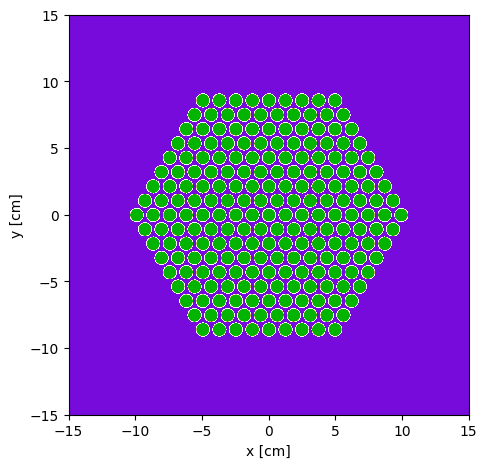

In [5]:
fuel_assembly_universe.plot(origin = (0,0,0),
                            pixels =(400, 400),
                            width = (30.,30.),
                            color_by = 'material')

In [6]:
#OPENMC SIMULATION PARAMETERS definition

#Source must be set: we create a uniform spatial source distribution over fissionable zones
lower_left = (-assembly_pitch/2, -assembly_pitch/2, -50)
upper_right = (assembly_pitch, assembly_pitch, +50)
uniform_distr = openmc.stats.Box(lower_left, upper_right, only_fissionable=True)
src = openmc.Source(space=uniform_distr)

#Settings indicate number of particles, active and inactive cycles
settings = openmc.Settings()

settings.source = src
settings.particles = 1000 # number of Neutrons per cycles
settings.batches = 100 #Total number of cycles
settings.inactive = 10 #Number of inactive cycles

settings.export_to_xml()

/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [7]:
#RUNNING OpenMC
#openmc.run()